# Image Classification of Australian Animals

William Li z5257749

The goal of the project is to create a model that can classify a selection of Australian animals. There are 8 animals:
- Cockatoo
- Dingo
- Kangaroo
- Koala
- Kookaburra
- Platypus
- Seadragon
- Wombat

The metric used to assess models is categorical accuracy.

## Import packages and set seed

In [1]:
%load_ext pycodestyle_magic

import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import itertools
import pickle
import hiplot as hip

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.utils import load_img, img_to_array, set_random_seed
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Resizing
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
set_random_seed(777)

## Data loading and preprocessing

Data is located in the "Data" folder, with images of each animal being in a different subfolder.

There are 200 images for each animal. The images were collected from Google Images with the help of the Image Downloader extension. 
https://chrome.google.com/webstore/detail/image-downloader/cnpniohnfphhjihaiiggeabnkjhpaldj 

They were selected manually to ensure accuracy and avoid duplicates (though the latter is not guaranteed as I can't perfectly recall 200 images)

In [3]:
labels = []
data_raw = []

folder_list = os.listdir('Data')
folder_list.sort()
for folder_name in folder_list:
    folder_path = os.path.join('Data', folder_name)
    
    # There are some system files that are not directories
    if not os.path.isdir(folder_path):
        continue
        
    file_list = os.listdir(folder_path)
    file_list.sort()
    for file_name in file_list:
        if file_name.endswith('.jpeg'):
            file_path = os.path.join(folder_path, file_name)
            img = load_img(file_path)
            img_array = img_to_array(img)
            #normalise inputs from [0, 255] to [0, 1]
            img_array /= 255
            
            data_raw.append(img_array)
            
            labels.append(folder_name)

In [4]:
labels = np.array(labels)

enc = OneHotEncoder(sparse=False)
labels_oh = enc.fit_transform(labels.reshape(-1,1))

train_test_split used 3 times to segment data into 4 sets. Their purpose and number of examples per class are:
- Training (96)
- Validation for early-stopping (32)
- Validation for hyperparameter tuning (32) and
- Test (40)

https://stats.stackexchange.com/questions/422671/early-stopping-together-with-hyperparameter-tuning-in-neural-networks

Using the same dataset for both early-stopping and hyperparameter tuning would mean choosing the epoch with the best performance on the dataset, while also evaluating model performance using that same dataset. This may result in an optimistic validation error.

The downside of having two validation sets is less training data for hyperparameter tuning. This disadvantage is not present for the final model however, as one of the validation sets can be combined into the training set at that point.

After considering the pros and cons, the choice was made to use 2 validation sets.

Validation set for early-stopping explicitly defined here rather than using validation_split in model.train as stratify is only available here.

In [5]:
X_train_val_raw, X_test_raw, y_train_val, y_test = train_test_split(
    data_raw, labels_oh, test_size=0.2, shuffle=True, random_state=777, stratify=labels)

X_train_es_raw, X_val_raw, y_train_es, y_val = train_test_split(
    X_train_val_raw, y_train_val, test_size=0.2, shuffle=True, random_state=777, stratify=y_train_val)

X_train_raw, X_es_raw, y_train, y_es = train_test_split(
    X_train_es_raw, y_train_es, test_size=0.25, shuffle=True, random_state=777, stratify=y_train_es)

In [6]:
def list_to_resized_array(img_list):
    return np.array([tf.image.resize(img, (128, 128)) for img in img_list])

In [7]:
#Resize images
X_train = list_to_resized_array(X_train_raw)
X_es = list_to_resized_array(X_es_raw)
X_val = list_to_resized_array(X_val_raw)
X_test = list_to_resized_array(X_test_raw)

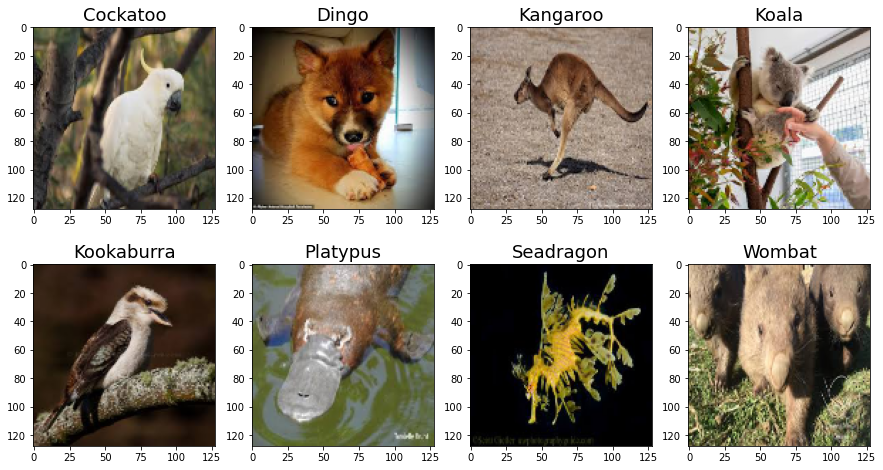

In [91]:
fig = plt.figure(figsize=(15,8))
for class_index in range(y_train.shape[1]):   
    plt.subplot(2, 4, class_index+1)
    image_index = np.where(y_train[:, class_index])[0][0]
    plt.imshow(X_train[image_index])
    plt.title(enc.categories_[0][class_index], fontdict={'fontsize': 18})
plt.savefig(os.path.join('Plots', 'animal_examples.jpg'), dpi=200)
plt.show()

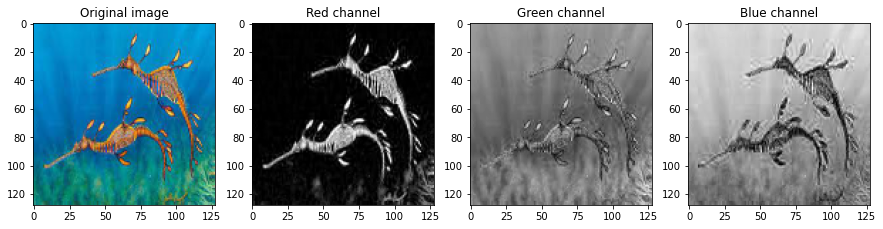

In [9]:
fig = plt.figure(figsize=(15, 5))
img_index=85

plt.subplot(1, 4, 1)
plt.imshow(X_train[img_index])
plt.title('Original image')

plt.subplot(1, 4, 2)
plt.imshow(X_train[img_index, :, :, 0], cmap='gray')
plt.title('Red channel')

plt.subplot(1, 4, 3)
plt.imshow(X_train[img_index, :, :, 1], cmap='gray')
plt.title('Green channel')

plt.subplot(1, 4, 4)
plt.imshow(X_train[img_index, :, :, 2], cmap='gray')
plt.title('Blue channel')

plt.savefig(os.path.join('Plots', 'colour_channels.jpg'), dpi=200)
plt.show()

### Image augmentation
Image augmentation may be helpful for the training set, as we have a fairly small dataset.

In [10]:
def zoom_corner(img_list, position='random', proportion=0.8, random_state=777):
    set_random_seed(random_state)
    new_img_list = []
    rand = position == 'random'
    
    for img in img_list:
        height = img.shape[0]
        width = img.shape[1]
        new_height = round(height*proportion)
        new_width = round(width*proportion)
        
        if rand:
            position = random.choice(['top-left', 'top-right', 'bottom-left', 'bottom-right'])
        
        if position == 'top-left':
            new_img = img[:new_height, :new_width, :]
        elif position == 'top-right':
            new_img = img[:new_height, -new_width:, :]
        elif position == 'bottom-left':
            new_img = img[-new_height:, :new_width, :]
        elif position == 'bottom-right':
            new_img = img[-new_height:, -new_width:, :]
        else:
            raise Exception("Invalid position")
        
        new_img_list.append(new_img)
        
    new_img_array = list_to_resized_array(new_img_list)
    return new_img_array

In [11]:
def rotate(img_list, rotation_angle, zoom_factor=-0.25, random_state=777):
    set_random_seed(random_state)
    new_img_list = []
    rotation_factor = rotation_angle/360
    
    seq = Sequential([
        #setting both lower and upper bound equal means deterministic behaviour
        RandomRotation((-rotation_factor, rotation_factor), fill_mode='reflect'),
        #Zoom in as rotation causes corners to be outside the boundaries
        RandomZoom((zoom_factor, zoom_factor))
    ])
    
    for img in img_list:
        
        new_img = seq(img, training=True)
        new_img_list.append(new_img)
    
    new_img_array = list_to_resized_array(new_img_list)
    return new_img_array

In [12]:
def augment_6x(X_raw):
    X = list_to_resized_array(X_raw)
    X_random_corner = zoom_corner(X_raw, position='random', random_state=777)
    X_rotate = rotate(X_raw, 12, random_state=777)
    X_flip = X[:, :, ::-1, :]
    X_random_corner_2 = zoom_corner(X_raw, position='random', random_state=778)
    X_random_corner_flip = X_random_corner_2[:, :, ::-1, :]
    X_rotate_2 = rotate(X_raw, 12, random_state=778)
    X_rotate_flip = X_rotate_2[:, :, ::-1, :]
    X_variations = [X, X_random_corner, X_rotate, X_flip, X_random_corner_flip, X_rotate_flip]
    X_aug = np.concatenate(X_variations)
    return X_aug

In [13]:
X_train_aug = augment_6x(X_train_raw)
y_train_aug = np.concatenate([y_train]*6)
X_es_aug = augment_6x(X_es_raw)
y_es_aug = np.concatenate([y_es]*6)

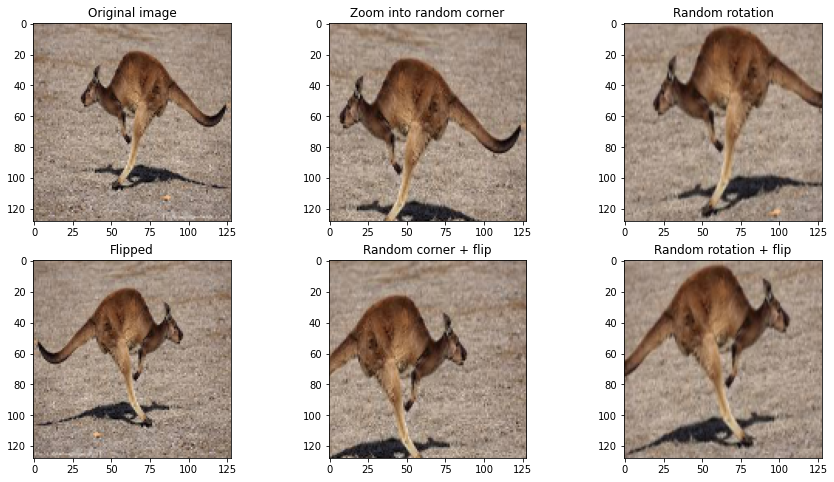

In [14]:
fig = plt.figure(figsize=(15, 8))
img_index = 0
n_train = len(X_train_raw)

plt.subplot(2, 3, 1)
plt.imshow(X_train_aug[img_index])
plt.title('Original image')

plt.subplot(2, 3, 2)
plt.imshow(X_train_aug[img_index+n_train*1])
plt.title('Zoom into random corner')

plt.subplot(2, 3, 3)
plt.imshow(X_train_aug[img_index+n_train*2])
plt.title('Random rotation')

plt.subplot(2, 3, 4)
plt.imshow(X_train_aug[img_index+n_train*3])
plt.title('Flipped')

plt.subplot(2, 3, 5)
plt.imshow(X_train_aug[img_index+n_train*4])
plt.title('Random corner + flip')

plt.subplot(2, 3, 6)
plt.imshow(X_train_aug[img_index+n_train*5])
plt.title('Random rotation + flip')

plt.savefig(os.path.join('Plots', 'augment_demo.jpg'), dpi=200)
plt.show()

In [15]:
#Shuffle after adding the modified images
set_random_seed(777)
perm = np.random.permutation(X_train_aug.shape[0])
X_train_aug = X_train_aug[perm]
y_train_aug = y_train_aug[perm]

perm_2 = np.random.permutation(X_es_aug.shape[0])
X_es_aug = X_es_aug[perm_2]
y_es_aug = y_es_aug[perm_2]

## Benchmark model: Logistic regression

In [16]:
def resize_array(img_array, new_size):
    img_array_small = []
    for img in img_array:
        img_array_small.append(tf.image.resize(img, new_size))
    return np.array(img_array_small)

In [17]:
#Logistic regression doesn't need early stopping, so the data can be used for training
X_train_lr = np.concatenate((X_train, X_es))
y_train_lr = np.concatenate((y_train, y_es))

#128x128 RGB has too many features for logistic regression, so resize 8x8 so there are 8*8*3=192 features
X_train_lr_8 = resize_array(X_train_lr, (8, 8))
X_val_8 = resize_array(X_val, (8, 8))

X_train_lr_flat = X_train_lr_8.reshape(X_train_lr.shape[0], -1)
X_val_flat = X_val_8.reshape(X_val.shape[0], -1)
y_train_lr_1d = np.argmax(y_train_lr, axis=1)
y_val_1d = np.argmax(y_val, axis=1)

num_classes = y_train_lr.shape[1]

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_lr_flat, y_train_lr_1d)
y_val_pred = lr_model.predict(X_val_flat)
np.mean(y_val_1d == y_val_pred)

0.46875

Logistic regression gives an accuracy of 46.88% in validation set. It is not great but considerably higher than random guessing (which would give an accuracy of 12.5%).

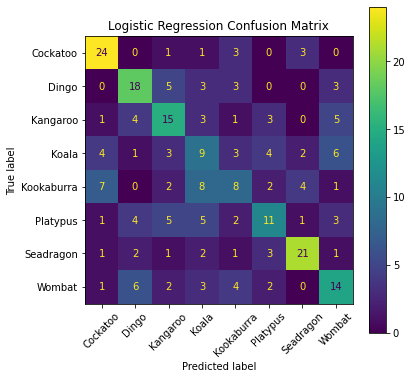

In [18]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Logistic Regression Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_val_1d, y_val_pred, ax=ax, display_labels=enc.categories_[0])
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(os.path.join('Plots', 'lr_confusion.jpg'), dpi=300, bbox_inches='tight')
plt.show()

In [19]:
coef = np.reshape(lr_model.coef_, (8, 64, 3))
np.mean(coef, axis=1)

array([[-0.10884977,  0.21965708,  0.02684798],
       [ 0.21846906, -0.11012405, -0.03689033],
       [ 0.18810467,  0.0357417 , -0.14228839],
       [-0.01978911, -0.01626659,  0.05525668],
       [-0.09489838,  0.06925463,  0.02926941],
       [ 0.00104886, -0.13906632,  0.01703609],
       [-0.34464121,  0.16420808,  0.00819848],
       [ 0.16055588, -0.22340453,  0.04257008]])

These are the average coefficients of each colour channel across all 64 pixels. It could be possible to interpret some of these coefficients. For example, the coefficient of red is reasonably positive on average for dingo and kangaroo classes, which is likely due to both animals having a reddish colour, and inhabiting drier areas which may have more red color. 

## Simple neural network

In [20]:
def define_simple_nn(resizing_size, neurons_1, neurons_2, neurons_3, dropout_rate, activation):
    model = Sequential()
    model.add(InputLayer(input_shape=(128, 128, 3)))
    model.add(Resizing(resizing_size, resizing_size))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons_1, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons_2, activation=activation))
    model.add(Dropout(dropout_rate))
    if neurons_3 is not None:
        model.add(Dense(neurons_3, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(8, activation='softmax'))
    return model

In [21]:
simple_nn_param_options = {
    'resizing_size':[8, 16, 32, 64],
    'neurons_1': [512, 1024],
    'neurons_2': [256, 512],
    'neurons_3': [None, 128, 256],
    'dropout_rate': [0, 0.2, 0.4],
    'activation': ['relu', 'tanh']
}

In [22]:
#Get all hyperparameter combinations by computing Cartesian product
simple_nn_combo_lists = itertools.product(*simple_nn_param_options.values())
simple_nn_combo_dicts = []
for combo in simple_nn_combo_lists:
    simple_nn_combo_dicts.append(dict(zip(simple_nn_param_options.keys(), combo)))
print(f"{len(simple_nn_combo_dicts)} hyperparameter combinations")

288 hyperparameter combinations


In [23]:
#Grid search code, takes 2 hours to run on my computer
"""
es = EarlyStopping(patience=20, restore_best_weights=True)
for param_combo in simple_nn_combo_dicts:
    print(param_combo)
    set_random_seed(777)
    model = define_simple_nn(**param_combo)
    model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es),
              batch_size=128, verbose=0)
    param_combo['train_loss'], param_combo['train_acc'] = model.evaluate(X_train, y_train, verbose=0)
    param_combo['es_loss'], param_combo['es_acc'] = model.evaluate(X_es, y_es, verbose=0)
    param_combo['val_loss'], param_combo['val_acc'] = model.evaluate(X_val, y_val, verbose=0)
    
simple_nn_df = pd.DataFrame(simple_nn_combo_dicts)
simple_nn_df.to_csv(os.path.join('Grid Search Results', 'simple_nn_grid_search.csv'), index=False)
"""

"\nes = EarlyStopping(patience=20, restore_best_weights=True)\nfor param_combo in simple_nn_combo_dicts:\n    print(param_combo)\n    set_random_seed(777)\n    model = define_simple_nn(**param_combo)\n    model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])\n    model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es),\n              batch_size=128, verbose=0)\n    param_combo['train_loss'], param_combo['train_acc'] = model.evaluate(X_train, y_train, verbose=0)\n    param_combo['es_loss'], param_combo['es_acc'] = model.evaluate(X_es, y_es, verbose=0)\n    param_combo['val_loss'], param_combo['val_acc'] = model.evaluate(X_val, y_val, verbose=0)\n    \nsimple_nn_df = pd.DataFrame(simple_nn_combo_dicts)\nsimple_nn_df.to_csv(os.path.join('Grid Search Results', 'simple_nn_grid_search.csv'), index=False)\n"

### Analyse grid search

In [24]:
simple_nn_df = pd.read_csv(os.path.join('Grid Search Results', 'simple_nn_grid_search.csv'))
exp = hip.Experiment.from_dataframe(simple_nn_df)
exp.display_data(hip.Displays.PARALLEL_PLOT).update(
    {'hide': ['train_loss', 'train_acc', 'es_loss', 'es_acc', 'val_loss']})
exp.display();

<IPython.core.display.Javascript object>

In [25]:
simple_nn_df.sort_values('val_acc', ascending=False)

resizing_size  neurons_1  neurons_2  neurons_3  dropout_rate activation  \
270             64       1024        512        NaN           0.0       relu   
133             16       1024        512      128.0           0.0       tanh   
109             16       1024        256        NaN           0.0       tanh   
110             16       1024        256        NaN           0.2       relu   
73              16        512        256        NaN           0.0       tanh   
..             ...        ...        ...        ...           ...        ...   
269             64       1024        256      256.0           0.4       tanh   
271             64       1024        512        NaN           0.0       tanh   
241             64        512        512      128.0           0.0       tanh   
281             64       1024        512      128.0           0.4       tanh   
217             64        512        256        NaN           0.0       tanh   

     train_loss  train_acc   es_loss    es_acc  val_loss   val_acc  
270    1.077177   0.630208  1.564916  0.421875  1.537749  0.496094  
133    0.844326   0.716146  1.562167  0.445312  1.542491  0.488281  
109    0.963983   0.675781  1.520753  0.484375  1.478022  0.488281  
110    0.939313   0.694010  1.496596  0.460938  1.487772  0.488281  
73     1.156322   0.587240  1.488302  0.472656  1.425003  0.488281  
..          ...        ...       ...       ...       ...       ...  
269    1.698996   0.305990  1.779831  0.312500  1.809487  0.273438  
271    1.697883   0.332031  1.773575  0.320312  1.801652  0.269531  
241    1.723647   0.283854  1.766525  0.261719  1.797953  0.257812  
281    1.741082   0.277344  1.800652  0.253906  1.804201  0.250000  
217    1.656128   0.328125  1.778982  0.277344  1.832167  0.246094  

[288 rows x 12 columns]

The best set of parameters resulted in an accuracy of 48.44%, slightly higher than logistic regression. However, it is quite likely that simple neural network is actually inferior to logistic regression as only 2 of the 288 parameter combinations outperformed it, which could easily be due to random variance.

### Train model with optimal hyperparameters and plot confusion matrix

In [26]:
set_random_seed(777)
model = define_simple_nn(resizing_size=16, neurons_1=1024, neurons_2=256, neurons_3=None,
                         dropout_rate=0, activation='tanh')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 16, 16, 3)         0         
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 1024)              787456    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)              

In [27]:
model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
es = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
hist = model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es), batch_size=128)

Epoch 1/100


2022-07-18 10:59:15.015984: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


36/36 [==============================] - 1s 23ms/step - loss: 2.3752 - categorical_accuracy: 0.2218 - val_loss: 1.8089 - val_categorical_accuracy: 0.2578
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 1.7045 - categorical_accuracy: 0.3576 - val_loss: 1.7230 - val_categorical_accuracy: 0.3320
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 1.6177 - categorical_accuracy: 0.3869 - val_loss: 1.7332 - val_categorical_accuracy: 0.3281
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 1.5562 - categorical_accuracy: 0.4078 - val_loss: 1.6542 - val_categorical_accuracy: 0.4102
Epoch 5/100
36/36 [==============================] - 0s 6ms/step - loss: 1.5170 - categorical_accuracy: 0.4264 - val_loss: 1.7098 - val_categorical_accuracy: 0.3516
Epoch 6/100
36/36 [==============================] - 0s 6ms/step - loss: 1.4894 - categorical_accuracy: 0.4373 - val_loss: 1.6039 - val_categorical_accuracy: 0.4297
Epoch 7/100
36/36 [==

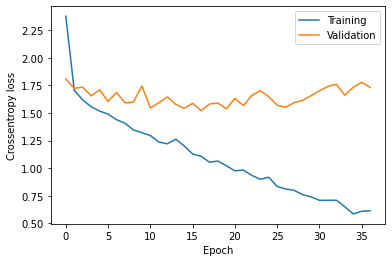

In [28]:
plt.plot(hist.history['loss'], label="Training")
plt.plot(hist.history['val_loss'], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Crossentropy loss")
plt.show()

In [29]:
model.evaluate(X_val, y_val)

8/8 [==============================] - 0s 4ms/step - loss: 1.4780 - categorical_accuracy: 0.4883


[1.4780216217041016, 0.48828125]

In [30]:
y_val_pred = model.predict(X_val)
#Convert from 2D array of probabilities to predictions
y_val_pred_1d = np.argmax(y_val_pred, axis=1)
y_val_1d = np.argmax(y_val, axis=1)

8/8 [==============================] - 0s 2ms/step


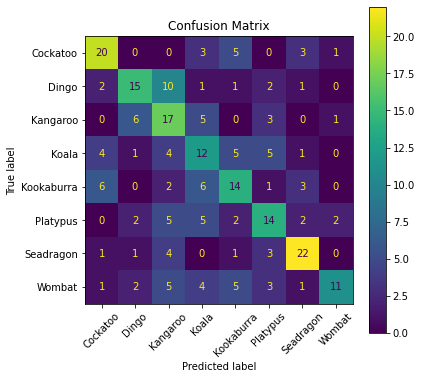

In [31]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_val_1d, y_val_pred_1d, ax=ax, display_labels=enc.categories_[0])
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(os.path.join('Plots', 'simple_nn_confusion.jpg'), dpi=300, bbox_inches='tight')
plt.show()

## Convolutional neural network

Basic structure takes inspiration from classic CNNs including LeNet and AlexNet

In [32]:
def define_cnn(kernel_size_1, kernel_size_2, pooling, dropout_rate, activation):
    Pooling2D = MaxPooling2D if pooling == 'max' else AveragePooling2D
    model = Sequential()
    model.add(InputLayer(input_shape=(128, 128, 3)))
    model.add(Conv2D(64, kernel_size_1, strides=4, padding='same', activation=activation))
    model.add(Pooling2D(2))
    model.add(Conv2D(128, kernel_size_2, strides=1, padding='same', activation=activation))
    model.add(Pooling2D(2))
    model.add(Conv2D(256, 3, strides=1, padding='same', activation=activation))
    model.add(Pooling2D(2))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(8, activation='softmax'))
    return model

In [33]:
cnn_param_options = {
    'kernel_size_1': [5, 7, 9, 11],
    'kernel_size_2': [3, 5],
    'pooling': ['average', 'max'],
    'dropout_rate': [0, 0.2, 0.4],
    'activation': ['relu', 'tanh']
}

In [34]:
#Get all hyperparameter combinations by computing Cartesian product
cnn_combo_lists = itertools.product(*cnn_param_options.values())
cnn_combo_dicts = []
for combo in cnn_combo_lists:
    cnn_combo_dicts.append(dict(zip(cnn_param_options.keys(), combo)))
print(f"{len(cnn_combo_dicts)} hyperparameter combinations")

96 hyperparameter combinations


In [35]:
#Takes multiple hours
"""
es = EarlyStopping(patience=20, restore_best_weights=True)
for param_combo in cnn_combo_dicts:
    print(param_combo)
    set_random_seed(777)
    model = define_cnn(**param_combo)
    model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es),
              batch_size=128, verbose=0)
    param_combo['train_loss'], param_combo['train_acc'] = model.evaluate(X_train, y_train, verbose=0)
    param_combo['es_loss'], param_combo['es_acc'] = model.evaluate(X_es, y_es, verbose=0)
    param_combo['val_loss'], param_combo['val_acc'] = model.evaluate(X_val, y_val, verbose=0)
    
cnn_df = pd.DataFrame(cnn_combo_dicts)
cnn_df.to_csv(os.path.join('Grid Search Results', 'cnn_grid_search.csv'), index=False)
"""

"\nes = EarlyStopping(patience=20, restore_best_weights=True)\nfor param_combo in cnn_combo_dicts:\n    print(param_combo)\n    set_random_seed(777)\n    model = define_cnn(**param_combo)\n    model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])\n    model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es),\n              batch_size=128, verbose=0)\n    param_combo['train_loss'], param_combo['train_acc'] = model.evaluate(X_train, y_train, verbose=0)\n    param_combo['es_loss'], param_combo['es_acc'] = model.evaluate(X_es, y_es, verbose=0)\n    param_combo['val_loss'], param_combo['val_acc'] = model.evaluate(X_val, y_val, verbose=0)\n    \ncnn_df = pd.DataFrame(cnn_combo_dicts)\ncnn_df.to_csv(os.path.join('Grid Search Results', 'cnn_grid_search.csv'), index=False)\n"

In [36]:
cnn_df = pd.read_csv(os.path.join('Grid Search Results', 'cnn_grid_search.csv'))
exp = hip.Experiment.from_dataframe(cnn_df)
exp.display_data(hip.Displays.PARALLEL_PLOT).update(
    {'hide': ['train_loss', 'train_acc', 'es_loss', 'es_acc', 'val_loss', 'uid']})
exp.display();

<IPython.core.display.Javascript object>

In [37]:
cnn_df.sort_values('val_acc', ascending=False).head(10)

kernel_size_1  kernel_size_2 pooling  dropout_rate activation  train_loss  \
83             11              3     max           0.4       tanh    0.213926   
81             11              3     max           0.2       tanh    0.094098   
45              7              5     max           0.2       tanh    0.175627   
19              5              5     max           0.0       tanh    0.179916   
23              5              5     max           0.4       tanh    0.224900   
31              7              3     max           0.0       tanh    0.111251   
57              9              3     max           0.2       tanh    0.234146   
9               5              3     max           0.2       tanh    0.269055   
35              7              3     max           0.4       tanh    0.151631   
7               5              3     max           0.0       tanh    0.155949   

    train_acc   es_loss    es_acc  val_loss   val_acc  
83   0.934896  1.043297  0.675781  0.848450  0.710938  
81   0.985677  1.014049  0.667969  0.902371  0.703125  
45   0.958333  0.993392  0.660156  0.944306  0.695312  
19   0.981771  0.980056  0.667969  0.938630  0.695312  
23   0.947917  0.909614  0.679688  1.002481  0.695312  
31   0.986979  0.976626  0.667969  0.954626  0.687500  
57   0.933594  0.994624  0.675781  0.898830  0.687500  
9    0.927083  0.891751  0.679688  0.924825  0.679688  
35   0.962240  0.979781  0.695312  0.960252  0.679688  
7    0.984375  0.906346  0.691406  0.959523  0.675781

### Train model with optimal hyperparameters and plot confusion matrix

In [70]:
set_random_seed(777)
model = define_cnn(kernel_size_1=11, kernel_size_2=3, pooling='max', dropout_rate=0.4, activation='tanh')
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        23296     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 4, 256)       

In [71]:
model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
es = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
hist = model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es), batch_size=128)

Epoch 1/100
36/36 [==============================] - 10s 267ms/step - loss: 2.0099 - categorical_accuracy: 0.2431 - val_loss: 1.6991 - val_categorical_accuracy: 0.3320
Epoch 2/100
36/36 [==============================] - 9s 252ms/step - loss: 1.7127 - categorical_accuracy: 0.3581 - val_loss: 1.5480 - val_categorical_accuracy: 0.4570
Epoch 3/100
36/36 [==============================] - 8s 216ms/step - loss: 1.5535 - categorical_accuracy: 0.4384 - val_loss: 1.3918 - val_categorical_accuracy: 0.5117
Epoch 4/100
36/36 [==============================] - 8s 217ms/step - loss: 1.4503 - categorical_accuracy: 0.4818 - val_loss: 1.3050 - val_categorical_accuracy: 0.5664
Epoch 5/100
36/36 [==============================] - 8s 230ms/step - loss: 1.3454 - categorical_accuracy: 0.5291 - val_loss: 1.2305 - val_categorical_accuracy: 0.5859
Epoch 6/100
36/36 [==============================] - 8s 233ms/step - loss: 1.2241 - categorical_accuracy: 0.5729 - val_loss: 1.2106 - val_categorical_accuracy: 0.59

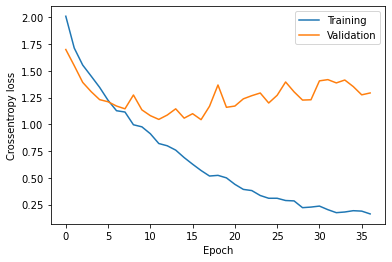

In [72]:
plt.plot(hist.history['loss'], label="Training")
plt.plot(hist.history['val_loss'], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Crossentropy loss")
plt.show()

In [74]:
model.evaluate(X_val, y_val)

8/8 [==============================] - 0s 18ms/step - loss: 0.8485 - categorical_accuracy: 0.7109


[0.8484503030776978, 0.7109375]

In [42]:
y_val_pred = model.predict(X_val)
#Convert from 2D array of probabilities to predictions
y_val_pred_1d = np.argmax(y_val_pred, axis=1)
y_val_1d = np.argmax(y_val, axis=1)

8/8 [==============================] - 0s 28ms/step


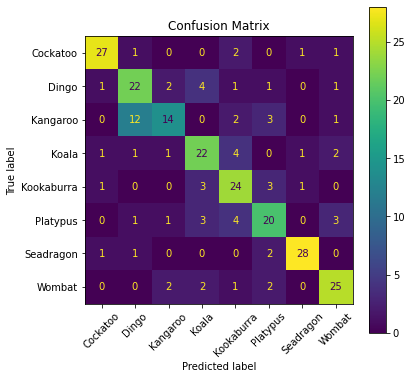

In [43]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_val_1d, y_val_pred_1d, ax=ax, display_labels=enc.categories_[0])
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(os.path.join('Plots', 'cnn_confusion.jpg'), dpi=300, bbox_inches='tight')
plt.show()

## Make final model and evaluate on test set

In [79]:
#Can use one of the validation sets for training now, leave the other for early stopping
X_train_final = np.concatenate((X_train_aug, X_es_aug))
y_train_final = np.concatenate((y_train_aug, y_es_aug))

In [80]:
set_random_seed(777)
final_model = define_cnn(kernel_size_1=11, kernel_size_2=3, pooling='max', dropout_rate=0.4, activation='tanh')
final_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        23296     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 4, 4, 256)      

In [81]:
final_model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
es = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
hist = final_model.fit(X_train_final, y_train_final, epochs=100, callbacks=[es],
                 validation_data=(X_val, y_val), batch_size=128)

Epoch 1/100
48/48 [==============================] - 13s 237ms/step - loss: 1.9323 - categorical_accuracy: 0.2637 - val_loss: 1.5152 - val_categorical_accuracy: 0.4805
Epoch 2/100
48/48 [==============================] - 10s 214ms/step - loss: 1.6270 - categorical_accuracy: 0.4090 - val_loss: 1.3210 - val_categorical_accuracy: 0.5508
Epoch 3/100
48/48 [==============================] - 10s 211ms/step - loss: 1.4551 - categorical_accuracy: 0.4777 - val_loss: 1.2472 - val_categorical_accuracy: 0.5781
Epoch 4/100
48/48 [==============================] - 10s 203ms/step - loss: 1.3721 - categorical_accuracy: 0.5203 - val_loss: 1.1947 - val_categorical_accuracy: 0.6016
Epoch 5/100
48/48 [==============================] - 10s 208ms/step - loss: 1.2478 - categorical_accuracy: 0.5682 - val_loss: 1.2188 - val_categorical_accuracy: 0.5781
Epoch 6/100
48/48 [==============================] - 10s 207ms/step - loss: 1.1743 - categorical_accuracy: 0.5869 - val_loss: 1.1072 - val_categorical_accuracy:

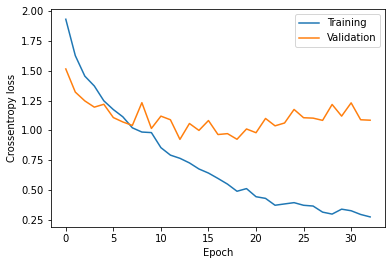

In [82]:
plt.plot(hist.history['loss'], label="Training")
plt.plot(hist.history['val_loss'], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Crossentropy loss")
plt.show()

In [83]:
final_model.evaluate(X_test, y_test)

10/10 [==============================] - 1s 24ms/step - loss: 1.0143 - categorical_accuracy: 0.6781


[1.0143098831176758, 0.6781250238418579]

In [84]:
y_test_pred = final_model.predict(X_test)
y_test_pred_1d = np.argmax(y_test_pred, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

10/10 [==============================] - 0s 19ms/step


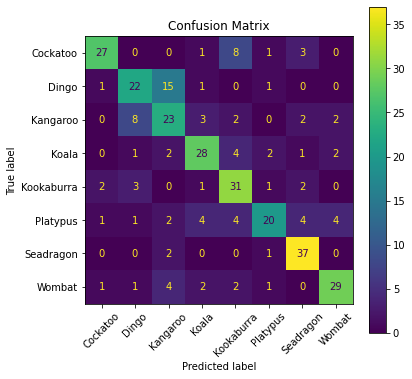

In [85]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test_1d, y_test_pred_1d, ax=ax, display_labels=enc.categories_[0])
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(os.path.join('Plots', 'test_confusion.jpg'), dpi=300, bbox_inches='tight')
plt.show()

### Showing predictions on some examples

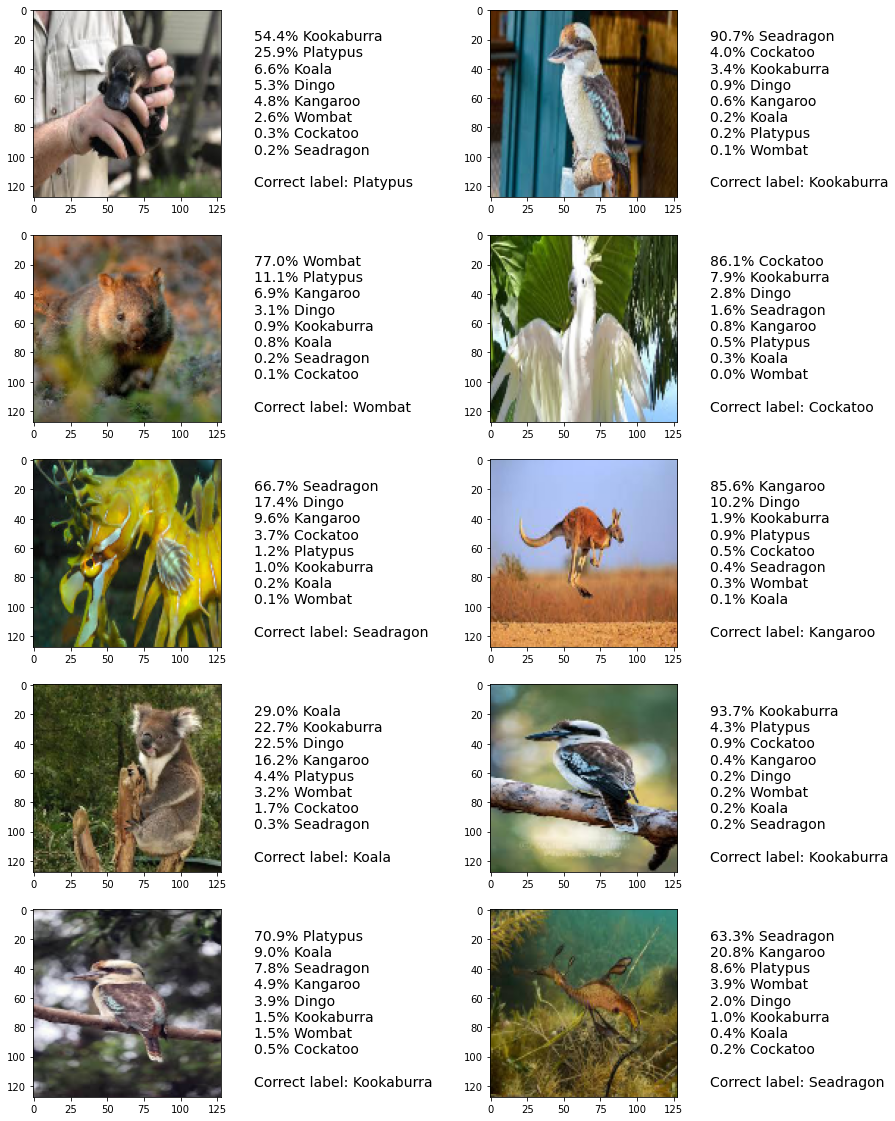

In [87]:
fig = plt.figure(figsize=(15, 20))

for i in range(10):
    categories = list(enc.categories_[0])
    pred = list(zip(list(y_test_pred[i]), categories))
    correct = categories[np.argmax(y_test[i])]
    pred.sort(reverse=True)
    pred_str=""
    for prob, animal in pred:
        pred_str += "{prob:.1%} {animal}\n".format(prob=prob, animal=animal)
    pred_str += "\nCorrect label: {label}".format(label=correct)
    ax = plt.subplot(5, 2, i+1)
    ax.imshow(X_test[i])
    ax.text(150, 120, pred_str, size=14)
plt.savefig(os.path.join('Plots', 'example_predictions.jpg'), dpi=200, bbox_inches='tight')
plt.show()

## Visualise filters and feature maps

To see the inner workings of the CNN
Method from https://www.kaggle.com/code/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn

### Filters

In [52]:
filters, bias = final_model.layers[0].get_weights()

In [53]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

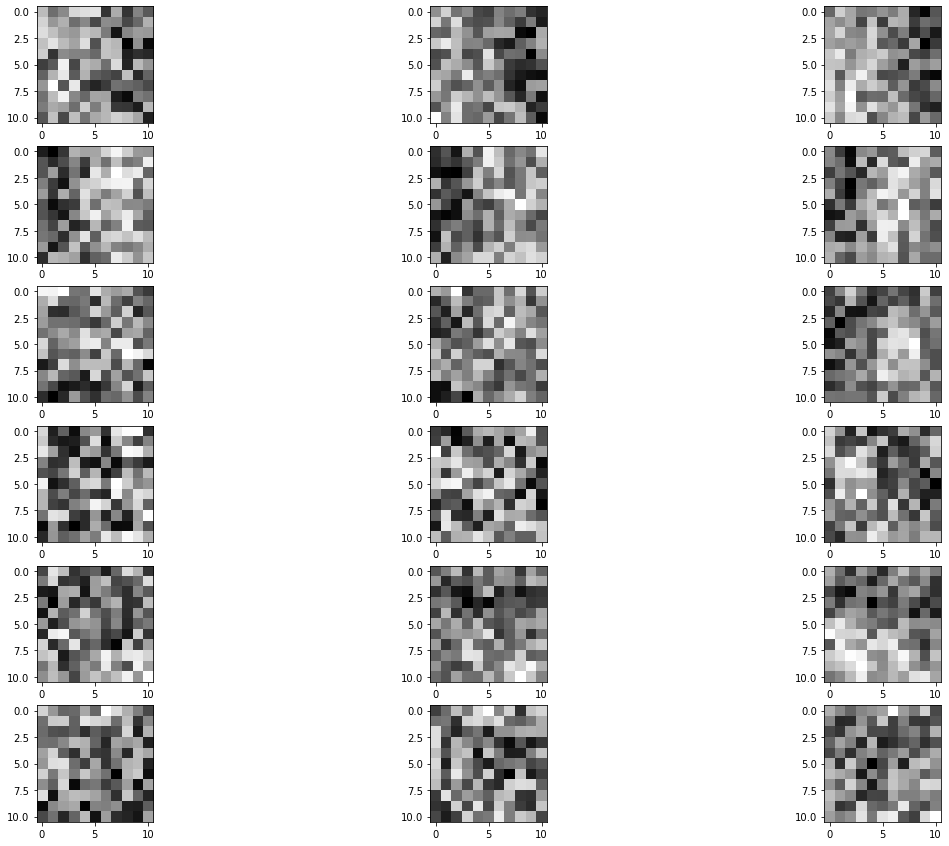

In [54]:
n_filters =6
ix = 1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
plt.show()

### Feature maps

In [55]:
for i in range(len(final_model.layers)):
    layer = final_model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

0 conv2d_3 (None, 32, 32, 64)
2 conv2d_4 (None, 16, 16, 128)
4 conv2d_5 (None, 8, 8, 256)


In [56]:
layers_idx = [0, 2, 4]
outputs = [final_model.layers[i].output for i in layers_idx]
visual_model = Model(inputs=final_model.inputs, outputs = outputs)

In [57]:
image = np.expand_dims(X_es[0], axis=0)

1/1 [==============================] - 0s 31ms/step


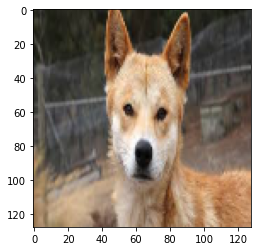

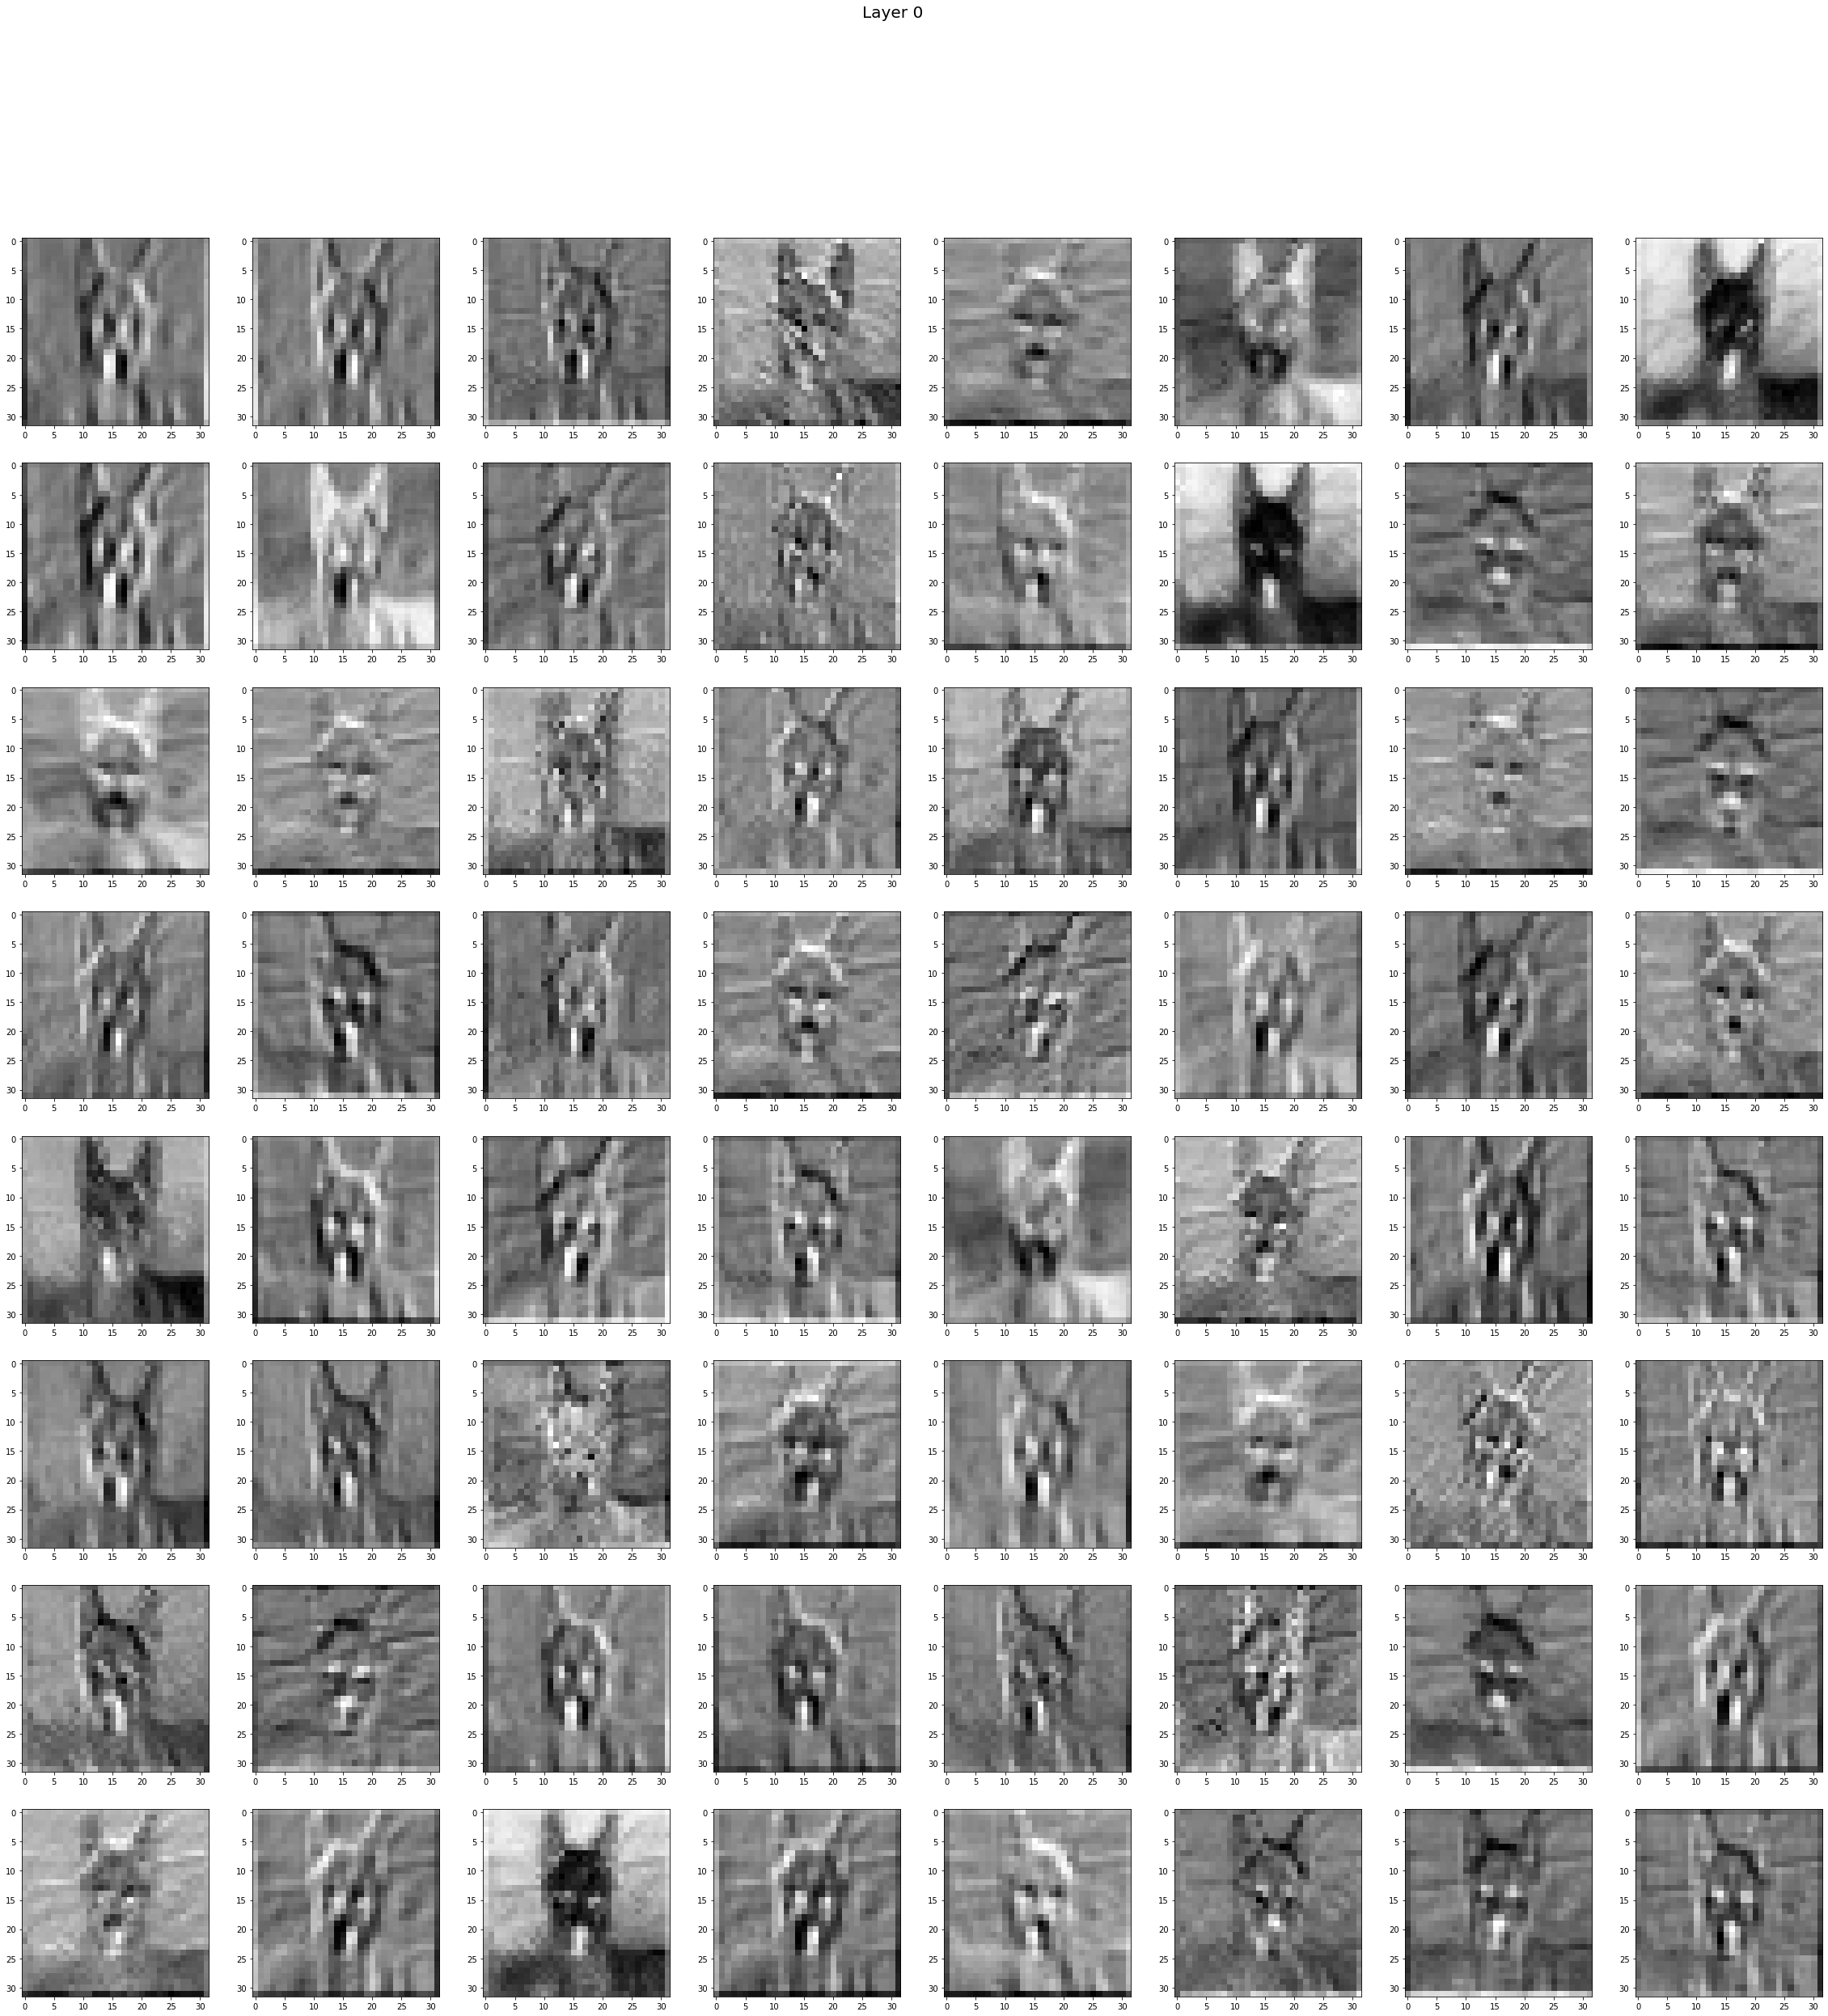

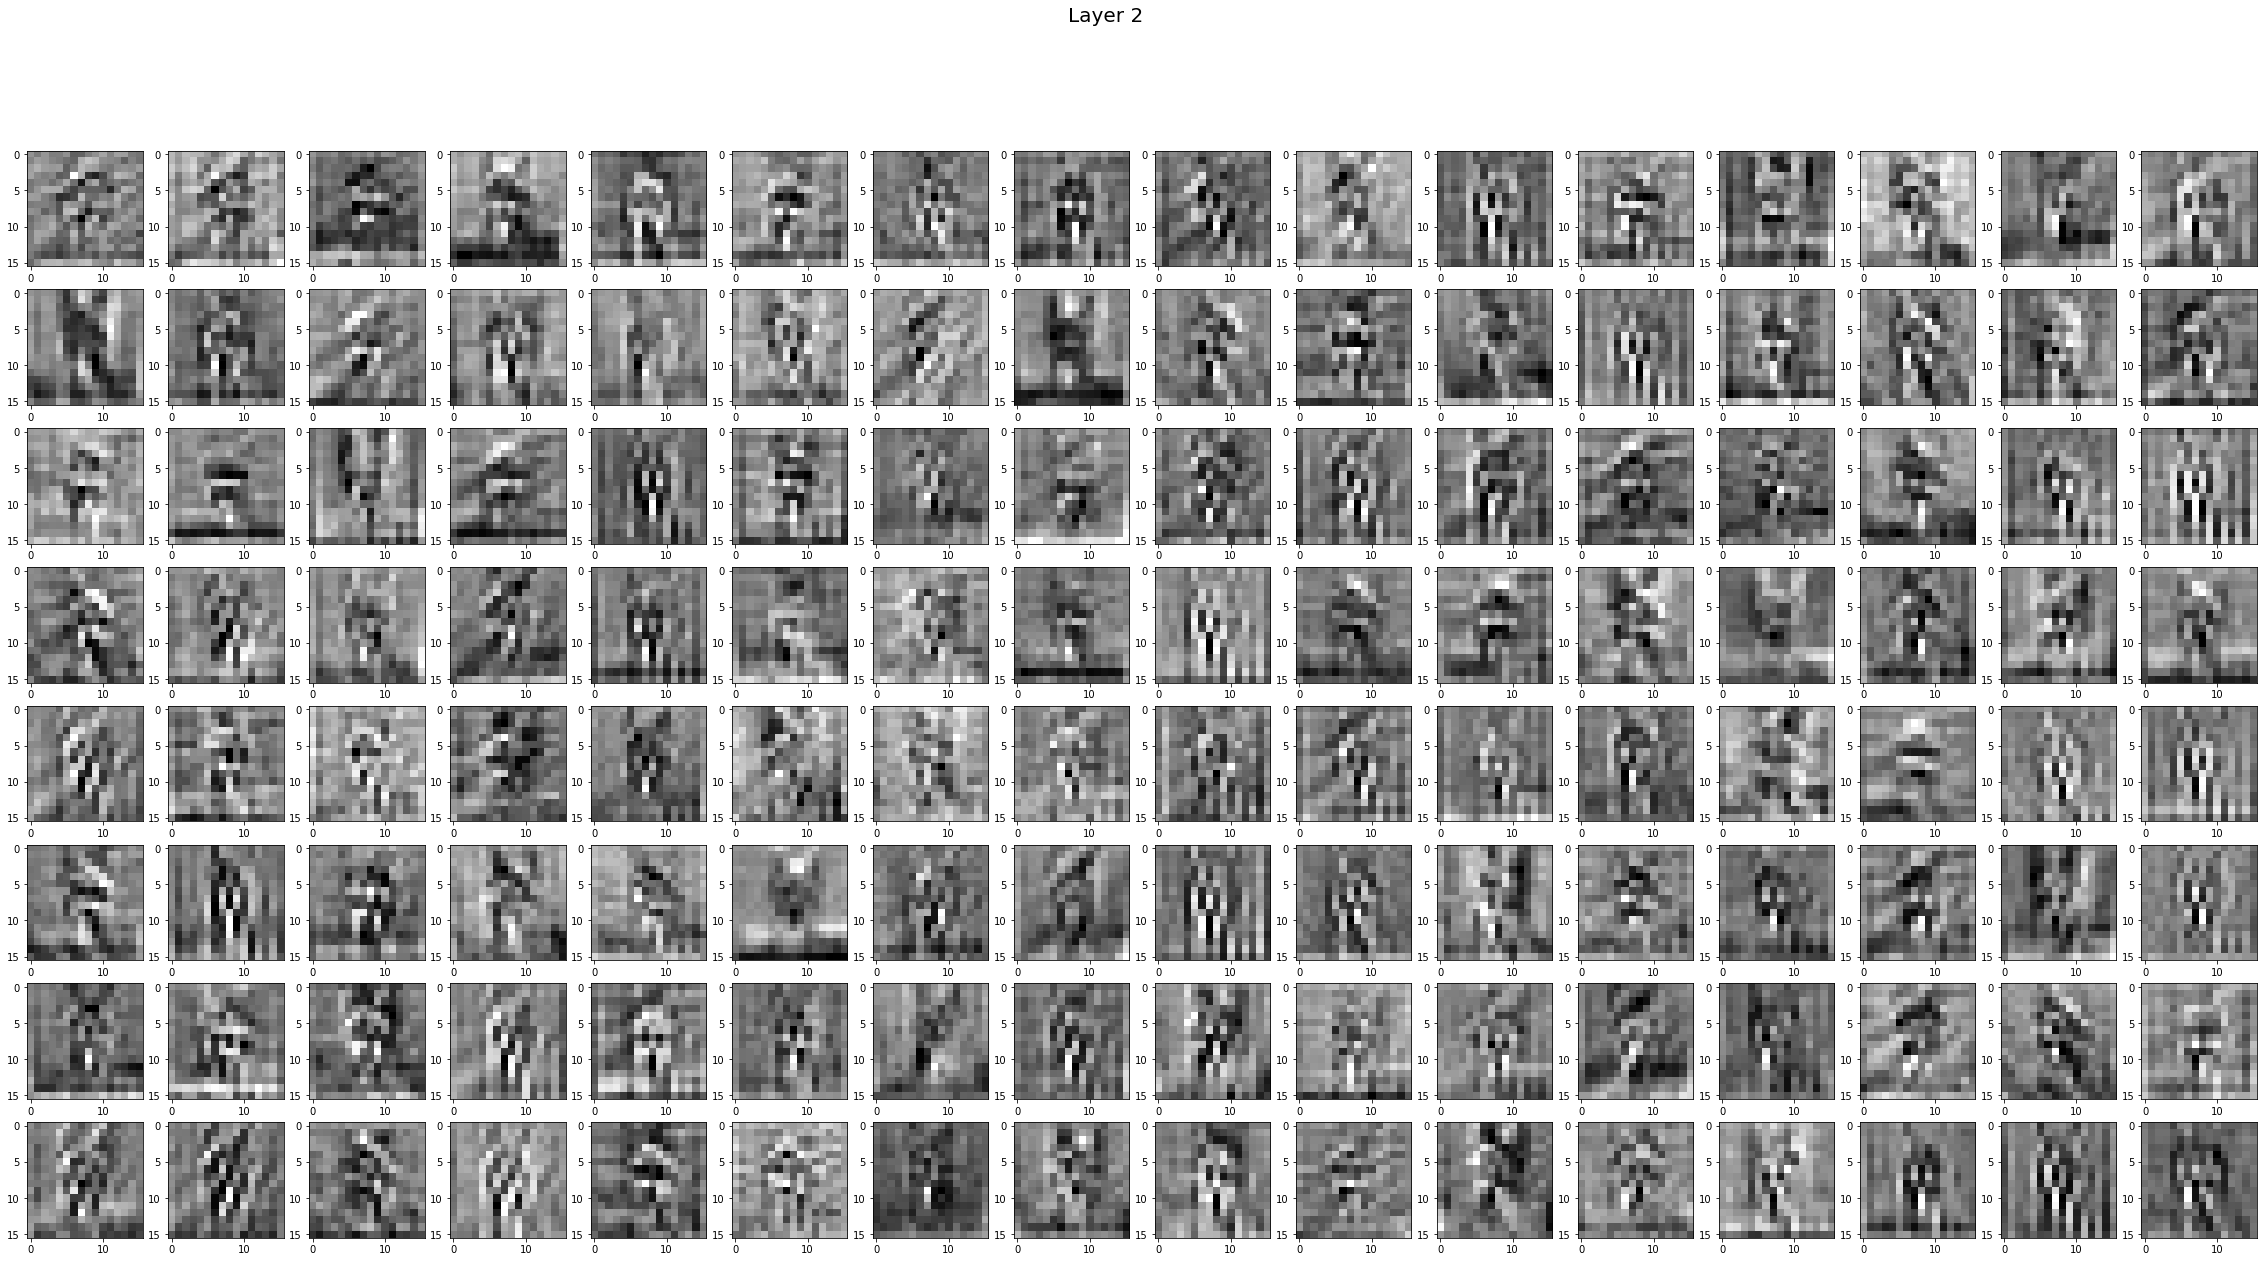

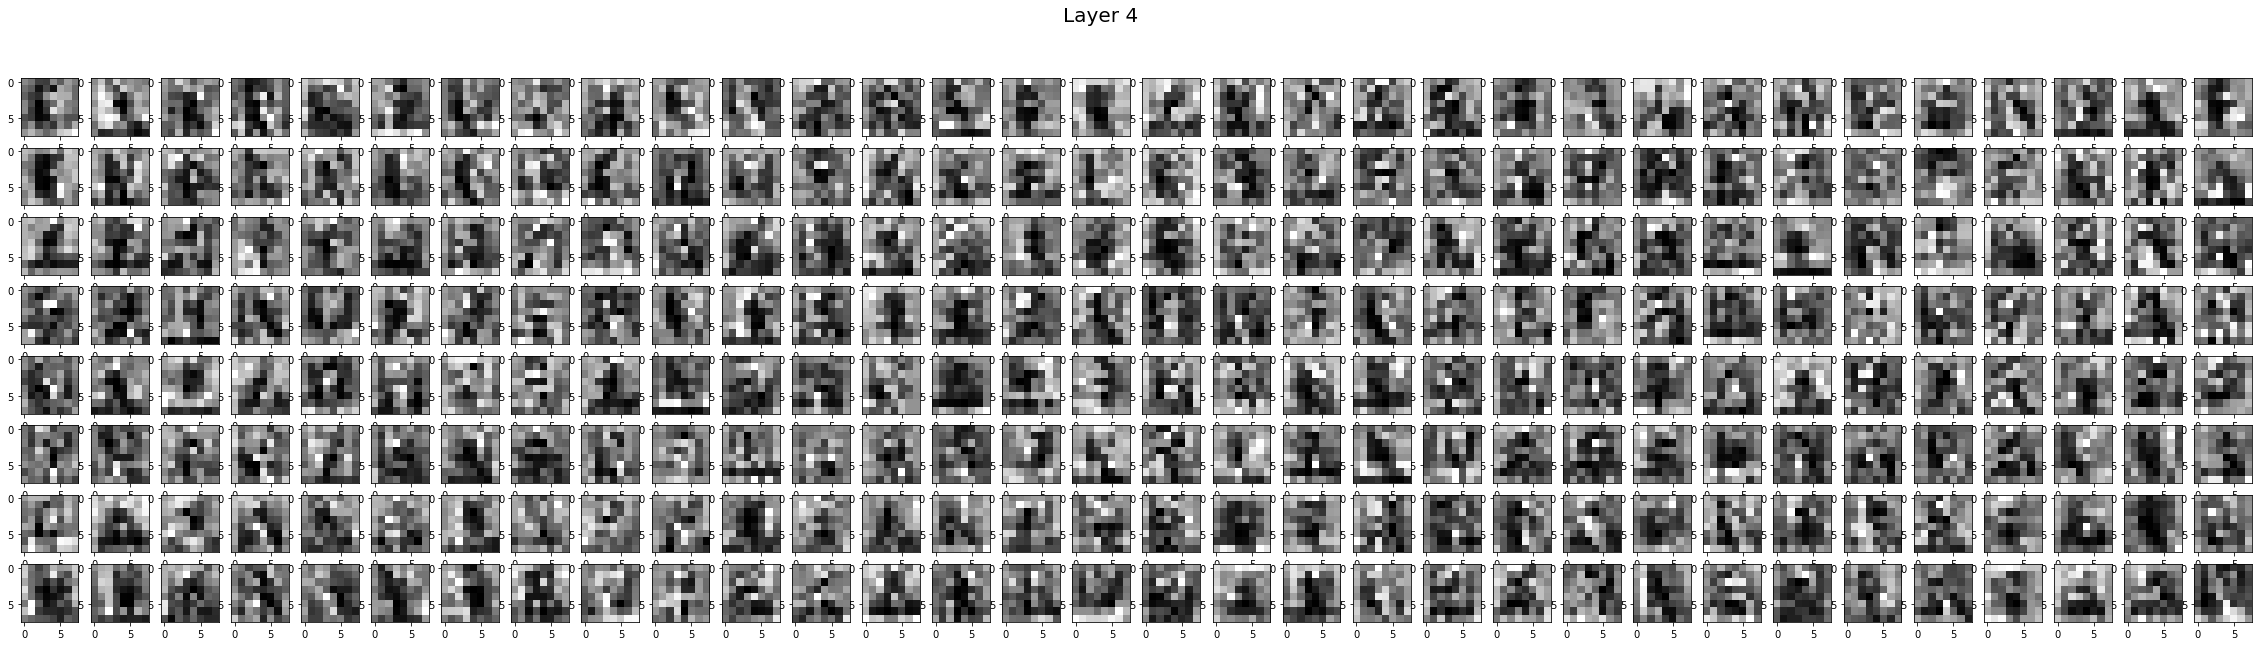

In [58]:
feature_map = visual_model.predict(image)

plt.imshow(X_es[0])
plt.show()

for i,fmap in zip(layers_idx, feature_map):
    
    
    fig = plt.figure(figsize=(40, 40/int(fmap.shape[3]/64)))
    fig.suptitle("Layer {}".format(i), fontsize=20)
    for i in range(fmap.shape[3]):

        plt.subplot(8, round(fmap.shape[3]/8), i+1)
        plt.imshow(fmap[0, :, :, i] , cmap='gray')
    
plt.show()